In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load and preprocess the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [ ]:
# Generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

In [ ]:
# Discriminator model
def build_discriminator(img_shape):
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))

    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))

    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# Build and compile the discriminator
img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])


In [ ]:
# Build and compile the generator
latent_dim = 100
generator = build_generator(latent_dim)


In [ ]:
# Build the GAN model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


In [ ]:
# Training the GAN
epochs = 10000
batch_size = 64
save_interval = 5000

for epoch in range(epochs + 1):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    labels_gan = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, labels_gan)

    # Print progress
    if epoch % 1000 == 0:
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Generate and save sample images
        generated_images = generator.predict(np.random.normal(0, 1, (25, latent_dim)))
        generated_images = 0.5 * generated_images + 0.5  # Rescale images to [0, 1]
        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
        plt.close()

    # Save models and generate images at specified intervals
    if epoch % save_interval == 0:
        # Save GAN model in a single file
        gan.save(f"gan_model_epoch_{epoch}.h5")


# Load GAN Models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the GAN model
gan_model_path = '/content/gan_model_epoch_10000.h5'

try:
    generator = load_model(gan_model_path)
    print("GAN model loaded successfully.")
except OSError as e:
    print(f"Error loading GAN model: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


GAN model loaded successfully.


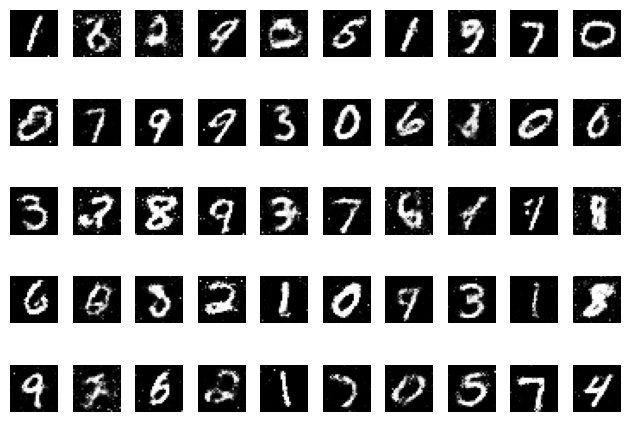

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.random import normal
import h5py

# Load the trained GAN model
gan_model_path = "gan_model_epoch_10000.h5"
gan_model = load_model(gan_model_path)

# Generate new images
num_generated_images = 50
latent_dim = 100

# Generate random noise samples as input to the generator
random_latent_vectors = normal(mean=0, stddev=1, shape=(num_generated_images, latent_dim))

# Generate images using the generator model
generated_images = gan_model.layers[1](random_latent_vectors)

# Rescale the generated images to the range [0, 1] if necessary
generated_images = 0.5 * generated_images + 0.5

# Save the generated images to an H5 file
output_h5_path = "generated_images.h5"
with h5py.File(output_h5_path, "w") as hf:
    hf.create_dataset("generated_images", data=generated_images.numpy())

# Display or save the generated images (optional)
for i in range(num_generated_images):
    plt.subplot(5, 10, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()
